In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
path = '/Users/dangloan/Documents/learning_analytics/project/'
path = '/Users/dangloan/Documents/learning_analytics/project/3_data/clothing_review'
path1 = '/Users/dangloan/Documents/learning_analytics/project/2_code/project_3/women-clothing/pickle'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)

## Read data

In [42]:
# Load raw data
df = pd.read_csv(path + '3_data/clothing_review/Womens Clothing E-Commerce Reviews.csv')

# Clean raw data
df.drop('Unnamed: 0', axis=1, inplace=True)
df.columns =['Clothing_ID','Age','Title','Review_Text','Rating',
             'Recommended_IND','Positive_Feedback_Count',
             'Division_Name','Department_Name','Class_Name']
#Clean data - Remove duplicates
df[df.duplicated(keep=False)].sort_values(by='Clothing_ID')
df.drop_duplicates(keep='first',inplace=True)

In [3]:
# Load preprocessed data ready for modeling. Read from clean_df
df2 = pd.read_pickle(path1 + '/clean_df.pkl')

## Problem Statement: Topic modeling by Clothing_ID

I'm trying to see what people complained about a product. Retailers can use the insights to prioritize improvement on the most frequently complained issues. The model segments negative review texts (low rating average, <3), and will give us an idea of what customers complain about the product on a review/purchase. I use topic modeling technique - LDA model. An expected result of the model would be that, for clothing id 1001, a negative review complained mostly about material.

Model output assessment: Human observations, Wordcound visualization.

Delivery: Each low rated Clothing Category receives top 3 prioritized areas of improvement for their product and service.

## Build LDA model

### Find the optimal number of topics

In [ ]:
# ! pip install gensim

In [68]:
import itertools
from gensim import corpora, models

import time
from tqdm import tqdm_notebook as tqdm

list_of_list_of_tokens = df2['tokens'].tolist()
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

start = 1
end = 30
step = 1
topic_range = range(start, end, step)

coherence_values = []
model_list = []
for num_topics in tqdm(topic_range):
    model = models.LdaMulticore(corpus=corpus,num_topics=num_topics,id2word=dictionary_LDA)
    model_list.append(model)
    coherencemodel = models.coherencemodel.CoherenceModel(model=model,
                                                                texts=list_of_list_of_tokens,
                                                                dictionary=dictionary_LDA,
                                                                coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

max_coherence_val = 0
optimal_model = None

# Print the coherence scores
for i, (m,cv) in enumerate(zip(topic_range, coherence_values)):
    if max_coherence_val < round(cv,4):
        optimal_model = model_list[i]
        optimal_num_topics = m
        max_coherence_val = round(cv,4)
        
        print("Numberof topics =", m , "has coherence value of" ,round(cv,4))




/Users/dangloan/miniconda3/envs/py/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Numberof topics = 1 has coherence value of 0.2282
Numberof topics = 2 has coherence value of 0.2628
Numberof topics = 3 has coherence value of 0.268
Numberof topics = 4 has coherence value of 0.2852
Numberof topics = 7 has coherence value of 0.2959
Numberof topics = 10 has coherence value of 0.3013


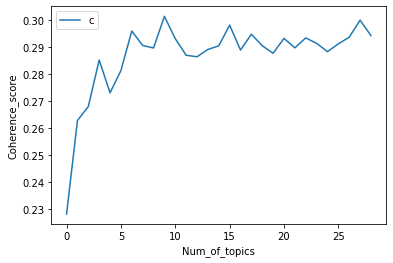

In [69]:
#Plot coherence results
import matplotlib.pyplot as plt
plt.plot(coherence_values)
plt.xlabel("Num_of_topics")
plt.ylabel("Coherence_score")
plt.legend('coherence_values', loc='best')
plt.show() 

In [4]:
import itertools
from gensim import corpora, models

# list_of_list_of_tokens = [["a","b","c"], ["d","e","f"]]
# ["a","b","c"] are the tokens of document 1, ["d","e","f"] are the tokens of document 2...

# df_pos['tokens'] = df_pos['Review_Text_lemmatized'].apply(
#     lambda x : list(itertools.chain.from_iterable(x)))
selected_num_topics = 7
list_of_list_of_tokens = df2['tokens'].tolist()
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

num_topics = selected_num_topics
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  random_state=123, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 18.2 s, sys: 159 ms, total: 18.4 s
Wall time: 19.5 s


In [327]:
print('Selected number of topics:', selected_num_topics)

# Compute perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good model is.
                                                             # lower is better
# Compute coherence score
coherence_model_lda = models.coherencemodel.CoherenceModel(model=lda_model,
                                                                texts=list_of_list_of_tokens,
                                                                dictionary=dictionary_LDA,
                                                                coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Selected number of topics: 7
Perplexity:  -7.582720714924128
Coherence Score:  0.323546680051018


In [328]:
print('Optimal number of topics:', optimal_num_topics)

# Compute perplexity
print('Perplexity: ', optimal_model.log_perplexity(corpus)) # a measure of how good model is.
                                                             # lower is better
# Compute coherence score
coherence_model_lda = models.coherencemodel.CoherenceModel(model=optimal_model,
                                                                texts=list_of_list_of_tokens,
                                                                dictionary=dictionary_LDA,
                                                                coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Optimal number of topics: 10
Perplexity:  -6.952561504890055
Coherence Score:  0.30131718182439393


From the coherence plot, there are two points of notice: 7 and 10 topics. The objective is to choose the smallest number of topics (lower perplexity score) with highest coherence score. From the coherence score and the perplexity score comparison of the two options, I choose the number of topics at 7.

## Visualize model output

In [93]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.054*"color" + 0.035*"material" + 0.019*"fit" + 0.014*"fabric" + 0.013*"waist" + 0.012*"soft" + 0.010*"picture" + 0.010*"return" + 0.009*"expect" + 0.009*"short" + 0.008*"style" + 0.008*"size" + 0.008*"design" + 0.008*"thin" + 0.008*"cut" + 0.007*"photo" + 0.007*"zipper" + 0.007*"boxy" + 0.007*"red" + 0.006*"cheap"

1: 0.025*"color" + 0.021*"fabric" + 0.018*"fit" + 0.018*"size" + 0.014*"white" + 0.013*"return" + 0.012*"small" + 0.011*"design" + 0.011*"black" + 0.010*"quality" + 0.010*"blue" + 0.009*"store" + 0.008*"retailer" + 0.008*"little" + 0.007*"time" + 0.007*"neck" + 0.007*"sleeve" + 0.007*"itchy" + 0.007*"tight" + 0.006*"front"

2: 0.030*"wash" + 0.020*"fit" + 0.018*"size" + 0.014*"fabric" + 0.014*"short" + 0.011*"line" + 0.010*"time" + 0.010*"dry" + 0.010*"waist" + 0.009*"stretch" + 0.009*"small" + 0.008*"button" + 0.008*"color" + 0.008*"leg" + 0.007*"inch" + 0.007*"comfortable" + 0.007*"front" + 0.006*"hand" + 0.006*"retailer" + 0.006*"year"

3: 0.068*"size" + 0.043*"small

In [329]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [332]:
pyLDAvis.save_html(vis, 'lda_pyLDAvis_211220.html')

In [21]:
topics = lda_model.show_topics(formatted=False)

In [24]:
dict(topics[1][1])

{'color': 0.025003236,
 'fabric': 0.020688076,
 'fit': 0.018050164,
 'size': 0.017925872,
 'white': 0.014308193,
 'return': 0.013046964,
 'small': 0.011901185,
 'design': 0.011265747,
 'black': 0.011239923,
 'quality': 0.010279068}

#### Word Clouds of Top N Keywords in Each Topic

IndexError: list index out of range

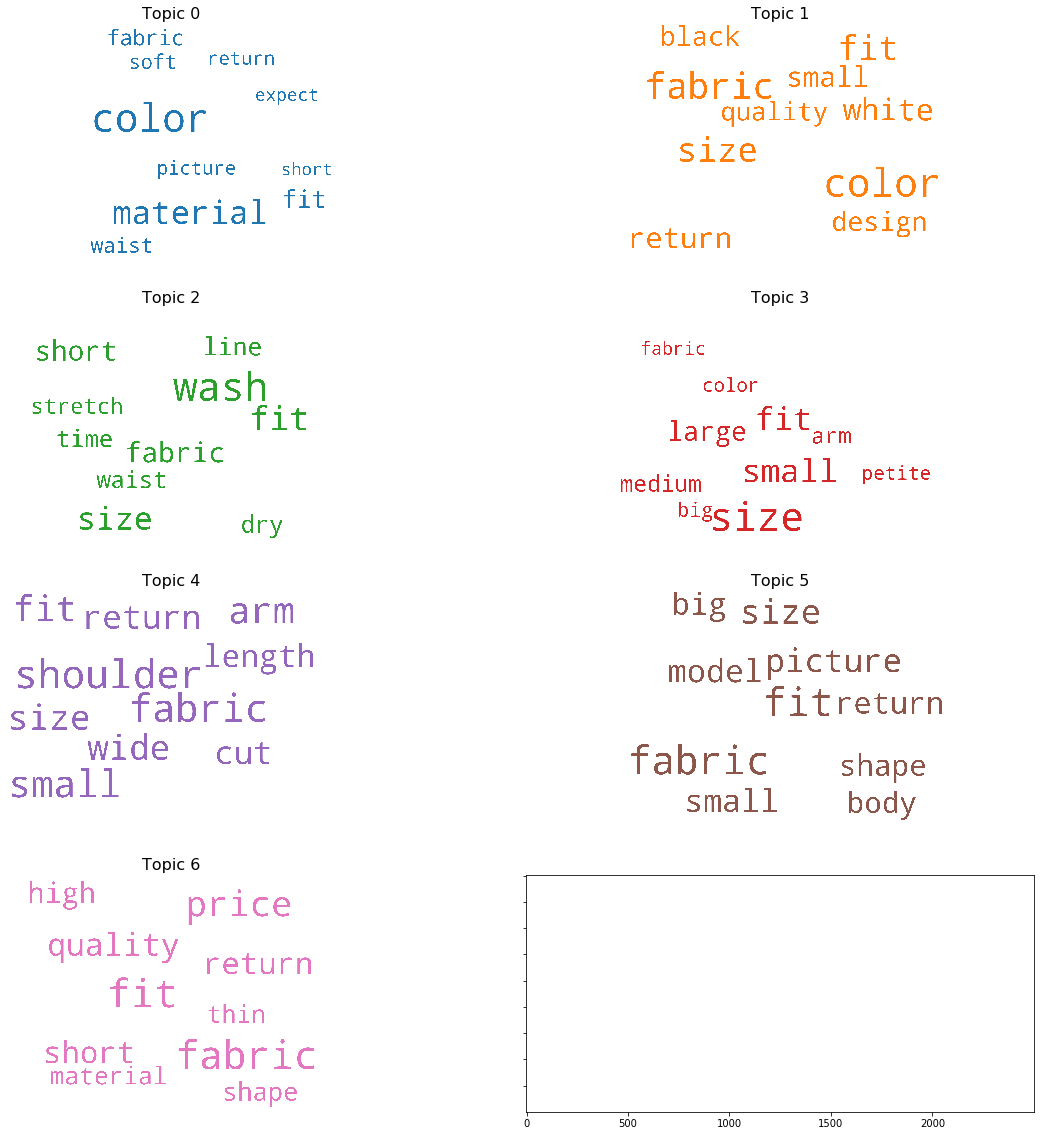

In [94]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Find meaning of topics in negative rating reviews (number of topics = 10):[23072020]\
Topic 0: Color/material\
Topic 1: Color/fabric\
Topic 2: Wash/dry/fit/stretch/fabric\
Topic 3: Size/small/large\
Topic 4: Shoulder/arm/length/wide/fabric\
Topic 5: Fabric/fit\
Topic 6: Fit/fabric/quality

#### Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

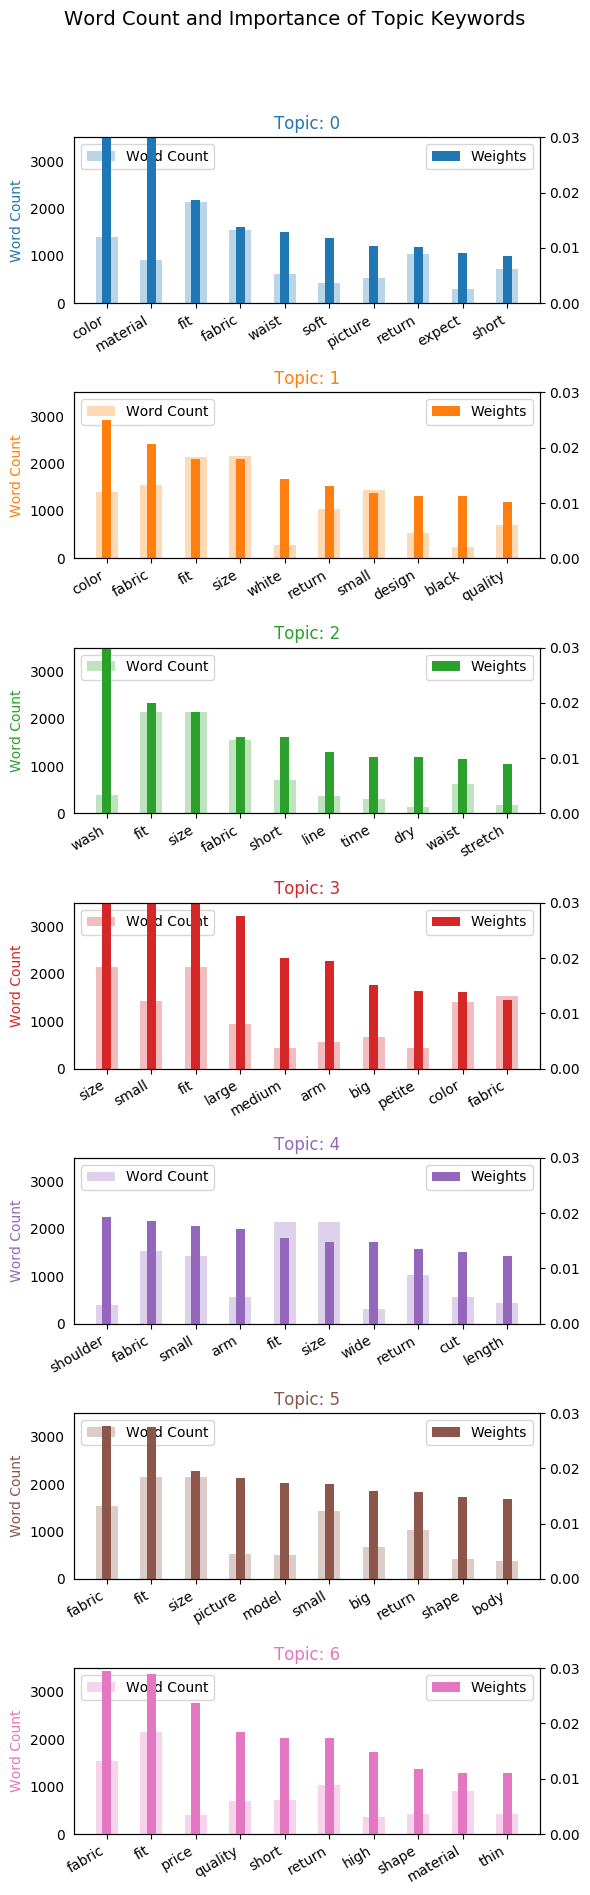

In [346]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in list_of_list_of_tokens for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(7, 1, figsize=(6,18), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=14, y=1.05)    
plt.show()

In [6]:
# Save model to disk.
# temp_file = datapath("model")
lda_model.save(path1 + 'lda.lda_model')
# Load a potentially pretrained model from disk.
# lda_model =  models.LdaModel.load('lda.lda_model')

### Assign dominant topic to document:
What is the Dominant topic and its percentage contribution in each document (weight)

In [5]:
topics = [lda_model[corpus[i]] for i in range(len(df2))]

In [6]:
len(topics)

5278

In [7]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [8]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [9]:
document_topic.head()

,0,1,2,3,4,5,6
0,0.000000,0.251003,0.000000,0.447193,0.000000,0.000000,0.300556
1,0.000000,0.000000,0.000000,0.000000,0.997281,0.000000,0.000000
2,0.219271,0.000000,0.776903,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.300035,0.235083,0.000000,0.463708,0.000000
4,0.000000,0.000000,0.495573,0.105756,0.000000,0.397010,0.000000


In [10]:
# Identify the dominant topic (the topic that has highest probability)
dominant_topic = np.argmax(document_topic.values, axis=1)
dominant_topic_perc = np.max(document_topic.values, axis=1)
document_topic['dominant_topic'] = dominant_topic
document_topic['dominant_topic_perc'] = dominant_topic_perc

In [11]:
def label_theme(row):
    if row['dominant_topic'] == 0 :
        return 'Color/material'
    if row['dominant_topic'] == 1 :
        return 'Color/fabric'
    if row['dominant_topic'] == 2 :
        return 'Wash/dry/fit/stretch/fabric'
    if row['dominant_topic'] == 3:
        return 'Size/small/large'
    if row['dominant_topic']  == 4:
        return 'Shoulder/arm/length/wide/fabric'
    if row['dominant_topic'] == 5:
        return 'Fabric/fit/body'
    if row['dominant_topic'] == 6:
        return 'Fit/fabric/price'


        
document_topic['dominant_topic_theme'] = document_topic.apply (lambda row: label_theme(row), axis=1)
document_topic.head(3)

,0,1,2,3,4,5,6,dominant_topic,dominant_topic_perc,dominant_topic_theme
0,0.000000,0.251003,0.000000,0.447193,0.000000,0.0,0.300556,3,0.447193,Size/small/large
1,0.000000,0.000000,0.000000,0.000000,0.997281,0.0,0.000000,4,0.997281,Shoulder/arm/length/wide/fabric
2,0.219271,0.000000,0.776903,0.000000,0.000000,0.0,0.000000,2,0.776903,Wash/dry/fit/stretch/fabric


In [12]:
# Tie dominant topic back to original data, 
# i.e. map LDA model result for each row to Clothing ID, Review Text, and Class Name
x=list(range(0,6,1))
x1 =df2[['Clothing_ID', 'Review_Text','Class_Name']].reset_index()
x1.drop('index', axis=1, inplace=True)
x2=document_topic[['dominant_topic','dominant_topic_perc','dominant_topic_theme'] + x]
y = pd.concat([x1,x2], axis=1)

In [22]:
y.sample(1)

,Clothing_ID,Review_Text,Class_Name,dominant_topic,dominant_topic_perc,dominant_topic_theme,0,1,2,3,4,5
4622,1095,"This dress is lovely fabric, generaly nicely tailored, but weirdly large around armholes, which gap. i'm sending it back. also this 'red' is more like a fuschia.\r\n dress was generally a a bit too big on top, oddly both too long in the torso, and the shoulders cut too far in--they didn't cover bra straps--as well as unattractively large armholes. you can even see it on the model. i i'm a size 10 to 12, fairly busty but not extremely, and with a slightly short torso, which is party the problem (th",Dresses,4,0.475025,Shoulder/arm/length/wide/fabric,0.0,0.0,0.0,0.453971,0.475025,0.0


### Number of documents by topic

In [23]:
a = document_topic.groupby('dominant_topic_theme')['dominant_topic'].count().reset_index()
a['percent'] = a['dominant_topic']/(a['dominant_topic'].sum(axis=0))*100
b = a.sort_values(['percent'],ascending=False)

In [24]:
b

,dominant_topic_theme,dominant_topic,percent
5,Size/small/large,1156,21.902236
0,Color/fabric,799,15.138310
2,Fabric/fit/body,796,15.081470
3,Fit/fabric/price,686,12.997347
4,Shoulder/arm/length/wide/fabric,625,11.841607
1,Color/material,621,11.765820
6,Wash/dry/fit/stretch/fabric,595,11.273210


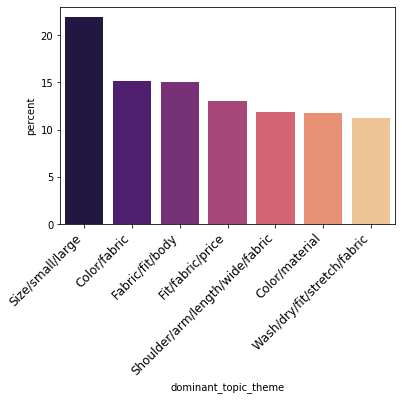

In [31]:
myplot = sns.barplot(x=b['dominant_topic_theme'], y=b['percent'], 
            palette='magma')
myplot.set_xticklabels(myplot.get_xticklabels(), rotation=45,
                     horizontalalignment='right',
                     fontweight='light',
                      fontsize='large');

<!-- Insights:
As a large portion of negative feedback was on Dress and Blouses, and Pants products (from exploratory analysis), LDA model output give us more insights into these groups of products:

The most frequently complained on Dress items was about size and fitability issues, followed by concerns about fabric/material. There's also a large portion of complains on Dress mentioning wash/color. This can be an issue with the deteriorated quality/color of the Dress after certain times being washed.
Another interesting problem is the issue at zipper and arm area. -->

Size is a prominant issue. Therefore, for products being complained small/large in size, the seller should provide more precise sizing information to customers and guarantee that the products are made with appropiate size as listed.

Compare LDA model output to WordCloud exploratory analysis (women_clothing_data_exploration.py) to see if the LDA topic modeling makes sense.

### Topic by Clothing Class

In [245]:
y.head(1)

,Clothing_ID,Review_Text,Class_Name,dominant_topic,dominant_topic_perc,dominant_topic_theme,0,1,2,3,4,5
0,1077,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",Dresses,3,0.447209,Size/small/large,0.0,0.250964,0.0,0.447209,0.0,0.0


In [36]:
crosstab = pd.crosstab(y['dominant_topic_theme'],y['Class_Name']).reset_index()
cols = crosstab.iloc[:, 1:].columns
crosstab.iloc[:, 1:] = crosstab.iloc[:, 1:]/crosstab.iloc[:, 1:].sum()

In [37]:
crosstab

Class_Name,dominant_topic_theme,Blouses,Dresses,Fine gauge,Intimates,Jackets,Jeans,Knits,Layering,Legwear,Lounge,Outerwear,Pants,Shorts,Skirts,Sleep,Sweaters,Swim,Trend
0,Color/fabric,0.133423,0.135560,0.174107,0.129032,0.192593,0.085,0.163993,0.25,0.21875,0.182540,0.200000,0.153025,0.119403,0.124352,0.166667,0.242857,0.0375,0.121951
1,Color/material,0.128032,0.116568,0.125000,0.032258,0.111111,0.065,0.130125,0.15,0.03125,0.142857,0.169231,0.074733,0.119403,0.124352,0.190476,0.120000,0.0250,0.170732
2,Fabric/fit/body,0.144205,0.187950,0.169643,0.096774,0.155556,0.105,0.143494,0.05,0.09375,0.111111,0.076923,0.106762,0.089552,0.160622,0.023810,0.088571,0.3375,0.219512
3,Fit/fabric/price,0.146900,0.130321,0.133929,0.032258,0.118519,0.085,0.139037,0.05,0.15625,0.134921,0.061538,0.078292,0.149254,0.165803,0.166667,0.142857,0.0750,0.097561
4,Shoulder/arm/length/wide/fabric,0.153639,0.109365,0.111607,0.161290,0.148148,0.040,0.131016,0.10,0.25000,0.150794,0.138462,0.060498,0.044776,0.051813,0.119048,0.162857,0.0250,0.170732
5,Size/small/large,0.219677,0.246234,0.200893,0.419355,0.177778,0.235,0.199643,0.20,0.09375,0.150794,0.246154,0.245552,0.149254,0.202073,0.214286,0.162857,0.4125,0.121951
6,Wash/dry/fit/stretch/fabric,0.074124,0.074001,0.084821,0.129032,0.096296,0.385,0.092692,0.20,0.15625,0.126984,0.107692,0.281139,0.328358,0.170984,0.119048,0.080000,0.0875,0.097561


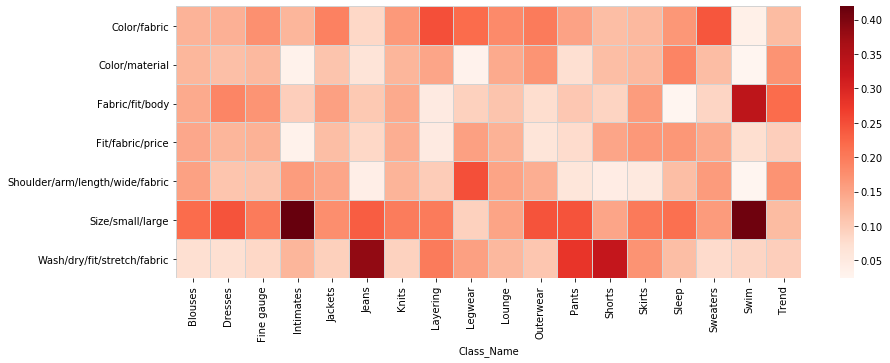

In [40]:
y_axis_labels = cols = crosstab.dominant_topic_theme.tolist()
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(crosstab.iloc[:,1:],
            yticklabels=y_axis_labels, 
            linewidths=0.01,
            linecolor='lightgrey',
            cmap="Reds")
# xticklabels=x_axis_labels

### Validate prediction by screening examples (human eyes)

In [181]:
!pip install openpyxl
sam = y.sample(50)
sam.to_excel(r'/Users/dangloan/Documents/learning_analytics/project/3_data/clothing_review/sample.xlsx', index = False)

    100% |████████████████████████████████| 245kB 2.4MB/s ta 0:00:01
  Stored in directory: /Users/dangloan/Library/Caches/pip/wheels/2a/77/35/0da0965a057698121fc7d8c5a7a9955cdbfb3cc4e2423cad39
Successfully built et-xmlfile


In [173]:
aa = y[y['Clothing_ID'] == 1110]
aa.groupby('dominant_topic_theme')['Clothing_ID'].count()

dominant_topic_theme
Color/fabric                       12
Color/material                     11
Fabric/fit                         17
Fit/fabric/quality                 13
Shoulder/arm/length/wide/fabric    11
Size/small                         30
Wash/dry/fit/stretch/fabric         9
Name: Clothing_ID, dtype: int64

After going through some sample and validate the reliability of the model prediction by 'eyes'. 27/57 reviews are correctly labeled (57%). For cases with dominant topic percentage (weight) is >= 0.9, 10/13 cases are correctly labeled (77%).

I also find out that there are some cases where the model predict incorrectly:\
    - Reviewers mention both on some aspects that they are and aren't satisfied with. The model picks keywords that were positively mentioned.\
    - People don't really express their opinion directly. They can use comparison, metaphors to say to indirectly express what they mean. For example, 'the dress looks like a nightgown on me' (i.e. sizing issue - the dress is too big for this customer).\
    - Sentences using negative form with **not** is also a challenge for the model to correctly articulate what the customers really mean.\
    - Some other cases are ones that show disappointment indirectly or in a ironic way. I haven't found any solution for these problem and would accept model inaccuracy caused by these problems.

I also find out that if the second dominant topic is around 0.3, it is worth select it is top topic as well. With that, we can say a review can mention more than 1 major issue of the product.

### Apply topics to Business Analysis:
Question: What are top purchase (top 20%) and negatively reviewed (Rating average (mean) < 3). Analyze what issues with these products, and send reccommendation to retailers on how they can improve their product.

I'm going to label the topic issues-wise (rather than item-and-issue-wise as the above):

In [192]:
a1 = df.groupby(['Clothing_ID']).agg({'Rating' : 'mean', 'Age' : 'count'}).reset_index()
a2 = a1[a1['Rating']<3]
a3 = a2.nlargest(int(round(len(a1)*0.2,0)),columns=['Age'])
a4 = a3.sort_values(['Rating','Age'],ascending=[True,False])
a4.head()
# print(int(round(len(a1)*0.2,0)))
# a3 = a2.head(int(round(len(a1)*0.2,0)))

,Clothing_ID,Rating,Age
973,973,1.0,2
759,759,1.0,1
118,118,1.0,1
812,812,1.0,1
814,814,1.0,1


int64
object


Text(0.5, 0, 'Count_ProductID')

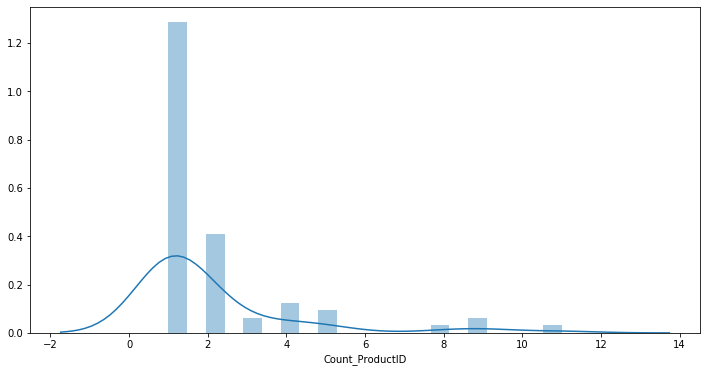

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
# a = df.groupby('Clothing_ID')['Age'].count().reset_index()
b = a2.sort_values(by='Age',ascending=False)
# b['Age'] = b['Age'].astype(int)
b['Clothing_ID'] = b['Clothing_ID'].astype(str)
print(b['Age'].dtype)
print(b['Clothing_ID'].dtype)

fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(b['Age'])
plt.xlabel('Count_ProductID')

In [ ]:
a4.describe()

I found out that there should be a method to choose which products need to be prioritized for improvement. I thought of:

- Method 1: Choose top 80% received largest number of reviews (nlargest_count) (dataset 1), then get products with average rating < 3.
This is unreasonable because the rating_mean of dataset 1 is around 4.19 (std ~ 0.3). There really is only one product from dataset 1 that has average rating <3.


- Method 2: Choose products with average rating < 3, then get top 80% received largest number of reviews (nlargest_count). This is also unfeaseable because the final selected products still have very small number of reviews (largely, from 1 to 2 reviews).

SO, we need another method.

In [194]:
## Method 1:
a1 = df.groupby(['Clothing_ID']).agg({'Rating' : 'mean', 'Age' : 'count'}).reset_index()
a2 = a1.nlargest(int(round(len(a1)*0.2,0)),columns=['Age'])
a3 = a2[a2['Rating'] <3]
print(a3.describe())
print(a2.describe())

       Clothing_ID    Rating   Age
count          1.0  1.000000   1.0
mean         229.0  2.181818  11.0
std            NaN       NaN   NaN
min          229.0  2.181818  11.0
25%          229.0  2.181818  11.0
50%          229.0  2.181818  11.0
75%          229.0  2.181818  11.0
max          229.0  2.181818  11.0
       Clothing_ID      Rating          Age
count   241.000000  241.000000   241.000000
mean    878.107884    4.163741    87.991701
std     252.781206    0.349924   133.802466
min      90.000000    2.181818     9.000000
25%     840.000000    3.962963    16.000000
50%     938.000000    4.192015    37.000000
75%    1052.000000    4.400000    96.000000
max    1203.000000    4.809524  1021.000000


In [195]:
## Method 2:
b0 = df[df['Rating'] <=2]
b1 = b0.groupby('Clothing_ID').agg({'Rating': ['count','mean','median']}).reset_index()
b1.columns = ['Clothing_ID','Rating_count','Rating_mean','Rating_median']
b1.describe()

,Clothing_ID,Rating_count,Rating_mean,Rating_median
count,391.000000,391.000000,391.000000,391.000000
mean,766.388747,6.156010,1.642581,1.707161
std,325.546259,10.998774,0.364128,0.425832
min,1.000000,1.000000,1.000000,1.000000
25%,551.000000,1.000000,1.500000,1.500000
50%,879.000000,2.000000,1.703704,2.000000
75%,1020.500000,6.000000,2.000000,2.000000
max,1195.000000,92.000000,2.000000,2.000000


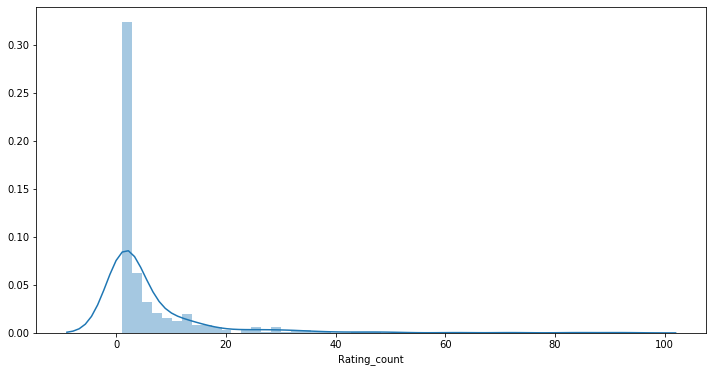

In [196]:
fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(b1['Rating_count'])

In [197]:
b2 = b1[b1['Rating_count'] >=6]

What we want is to select products receiving a certain number of negative reviews. These number of reviews should be large enough to show that retailers needs to care for improvement, but not some personal negative reviews (a very small number of negative reviews in comparison with the total number of reviews/total number of purchases).

On average, a product would receive ~ 6 (mean of Rating_count 6.15) negative reviews (Rating <=2).

In [198]:
b2.describe()

,Clothing_ID,Rating_count,Rating_mean,Rating_median
count,106.000000,106.000000,106.000000,106.000000
mean,955.735849,18.075472,1.649835,1.849057
std,101.333518,15.784681,0.155821,0.346203
min,818.000000,6.000000,1.272727,1.000000
25%,864.250000,8.250000,1.556548,2.000000
50%,940.500000,12.000000,1.666667,2.000000
75%,1067.500000,22.500000,1.738558,2.000000
max,1121.000000,92.000000,2.000000,2.000000


In [199]:
c1 = df[df['Clothing_ID'].isin(b2['Clothing_ID'])]
c2 = c1.groupby(['Clothing_ID']).agg({'Rating' : 'mean', 'Age' : 'count'}).reset_index()
# a2 = a1[a1['Rating']<3]
# a3 = a2.nlargest(int(round(len(a1)*0.2,0)),columns=['Age'])
c3 = c2.sort_values(['Rating','Age'],ascending=[True,False])
c3.head()
# print(int(round(len(a1)*0.2,0)))
# a3 = a2.head(int(round(len(a1)*0.2,0)))

,Clothing_ID,Rating,Age
56,946,2.444444,9
49,929,3.200000,20
57,948,3.200000,10
67,1016,3.333333,24
75,1055,3.360000,25


int64
object


Text(0.5, 0, 'Count_ProductID')

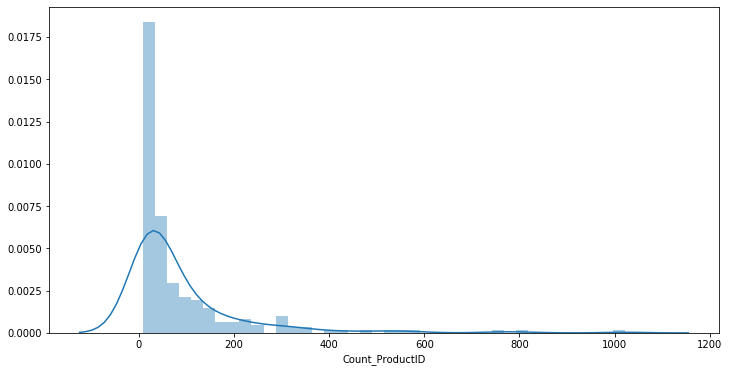

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
a = df.groupby('Clothing_ID')['Age'].count().reset_index()
b = a2.sort_values(by='Age',ascending=False)
# b['Age'] = b['Age'].astype(int)
b['Clothing_ID'] = b['Clothing_ID'].astype(str)
print(b['Age'].dtype)
print(b['Clothing_ID'].dtype)

fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(b['Age'])
plt.xlabel('Count_ProductID')

In [45]:
e = df.groupby('Clothing_ID')['Rating'].agg({'count','mean'}).reset_index()
e.columns =['Clothing_ID','R_mean','R_count']

print(e.describe())
print(e.R_count.quantile(0.9))

       Clothing_ID       R_mean      R_count
count  1206.00000   1206.000000  1206.000000
mean   602.50000    4.198509     19.456882  
std    348.28652    0.849257     68.868479  
min    0.00000      1.000000     1.000000   
25%    301.25000    4.000000     1.000000   
50%    602.50000    4.333333     2.000000   
75%    903.75000    5.000000     6.750000   
max    1205.00000   5.000000     1021.000000
36.5


Text(0.5, 1.0, 'Rating Statistics for Priority List')

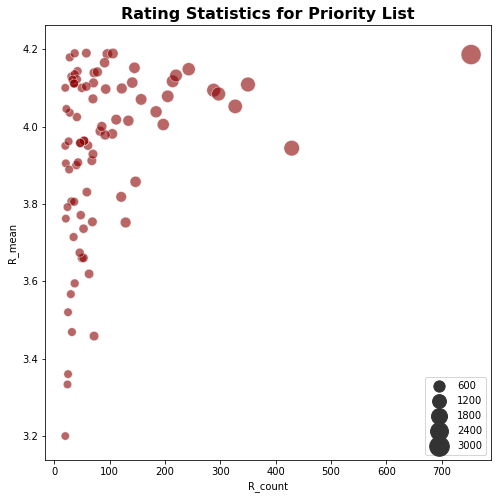

In [69]:
import seaborn as sns
e1 = e[(e['R_count']>19.5) & (e['R_mean']<4.19)]
# e1 = copy.deepcopy(e)
plt.figure(figsize=(8,8))
sns.scatterplot(e1['R_count'], e1['R_mean'], size = e1['R_count']*e1['R_mean'],
                sizes=(70, 400), color='darkred', alpha=0.6)
plt.title("Rating Statistics for Priority List", 
          fontsize=16,fontweight='bold')

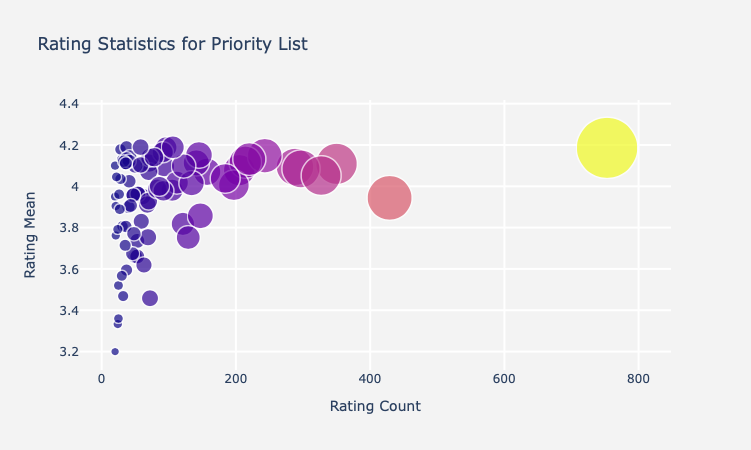

In [66]:
# A better visualization for exploration using plotly
import plotly.graph_objects as go
fig = go.Figure()
size = [20, 40, 60, 80, 100, 80, 60, 40, 20, 40]
fig = go.Figure(data=[go.Scatter(
    x=e1['R_count'],
    y=e1['R_mean'],
    text=e1['Clothing_ID'],
    mode='markers',
    marker=dict(
        size=e1['R_count']*e1['R_mean'],
        sizemode='area',
        sizeref=2.*max(size)/(60.*2),
        sizemin=4,
        line_width=1.5,
        color=e1['R_count']
    )
)])

fig.update_layout(
    title='Rating Statistics for Priority List',
    xaxis=dict(
        title='Rating Count',
        gridcolor='white',
        gridwidth=2,
    ),
    yaxis=dict(
        title='Rating Mean',
        gridcolor='white',
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)
fig.show()

In [47]:
len(e1)

84

In [72]:
test = y[y['Clothing_ID'] == 1087]
test.groupby('dominant_topic_theme')['Clothing_ID'].count().reset_index()\
            .sort_values('Clothing_ID',ascending=False)

,dominant_topic_theme,Clothing_ID
2,Fabric/fit/body,13
0,Color/fabric,8
1,Color/material,8
3,Fit/fabric/price,6
4,Shoulder/arm/length/wide/fabric,5
5,Size/small/large,5
6,Wash/dry/fit/stretch/fabric,2


In [55]:
e1[e1['Clothing_ID'] == 1087]

,Clothing_ID,R_mean,R_count
1087,1087,3.751938,129


In [74]:
len(df[(df['Clothing_ID']==1087) & (df['Rating'] <=2)])

29